In [20]:
ls

Bc_epitopes_HLA_overlap-05-06-20.txt
Select vaccine peptides.ipynb
Window_15mer-05-06-20.txt
Window_15mer-05-07-20.csv
Window_15mer-05-08-20.csv
Window_21mer-05-06-20.txt
Window_21mer-05-07-20.csv
Window_21mer-05-08-20.csv
Window_27mer-05-06-20.txt
Window_27mer-05-07-20.csv
Window_27mer-05-08-20.csv
vaccine-peptides-15mer-annotated-05-07-20.csv
vaccine-peptides-21mer-annotated-05-07-20.csv
vaccine-peptides-27mer-annotated-05-07-20.csv


In [21]:
df_15mer = pd.read_csv("Window_15mer-05-08-20.csv")
df_21mer = pd.read_csv("Window_21mer-05-08-20.csv")
df_27mer = pd.read_csv("Window_27mer-05-08-20.csv")


In [22]:
extremely_unstable_dipeptides_unc = {
  "DG",
  "NG",
}
problematic_dipeptides_unc = {
   "DS", 
   "DN", 
   "DD", 
   "NN", 
   "ND", 
   "NS",
}


problematic_dipeptides_jpt = {"NP"}

problematic_dipeptides = problematic_dipeptides_unc.union(problematic_dipeptides_jpt)

In [23]:
hydropathy_dict = {
    "A": 1.8,
    "C": 2.5,
    "D": -3.5,
    "E": -3.5,
    "F": 2.8,
    "G": -0.4,
    "H": -3.2,
    "I": 4.5,
    "K": -3.9,
    "L": 3.8,
    "M": 1.9,
    "N": -3.5,
    "P": -1.6,
    "Q": -3.5,
    "R": -4.5,
    "S": -0.8,
    "T": -0.7,
    "V": 4.2,
    "W": -0.9,
    "Y": -1.3
}

In [24]:

def gravy_score(amino_acids):
    """
    Mean amino acid hydropathy averaged across residues of a peptide
    or protein sequence.
    """
    total = 0 
    for aa in amino_acids:
        total += hydropathy_dict[aa]
    return total / len(amino_acids)


In [25]:

def max_kmer_gravy_score(amino_acids, k):
    """
    Returns max GRAVY score of any kmer in the amino acid sequence,
    used to determine if there are any extremely hydrophobic regions within a
    longer amino acid sequence.
    """
    return max(
        gravy_score(amino_acids[i:i + k])
        for i in range(len(amino_acids) - k + 1))


In [26]:
def max_short_subsequence_gravy_score(amino_acids):
    gravy_scores = [
        max_kmer_gravy_score(amino_acids, k)
        for k in [5, 6, 7, 8]
    ]
    return max(gravy_scores)


In [27]:


def difficult_c_terminal(amino_acids):
    return amino_acids[-1] in {"P", "C", "H"}

def difficult_n_terminal(amino_acids):
    """
    Is the N-terminus one of {Gln, Glu, Cys}?
    ---
    Priority I: avoid N-terminal Gln, Glu, Cys
    Priority II: Asparagine at the N-terminus of a peptide is also hard
    to synthesize, though not as bad as {Gln, Glu, Cys}
    """
    return amino_acids[0] in {"Q", "E", "C", "N"}


def cysteine_count(amino_acids):
    """
    How many cysteines are in the amino acid sequence?
    Problem with cysteine residues: They can form disulfide bonds across
    distant parts of the peptide
    """
    return amino_acids.count("C")

def methionine_count(amino_acids):
    """
    How many methionies?
    """
    return amino_acids.count("M")

def thiol_count(amino_acids):
    return cysteine_count(amino_acids) + methionine_count(amino_acids)

def num_extremely_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in extremely_unstable_dipeptides_unc:
        total += amino_acids.count(dipeptide)
    return total
    extremely_unstable_dipeptides_unc

def num_moderately_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in problematic_dipeptides_unc.union(problematic_dipeptides_jpt):
        total += amino_acids.count(dipeptide)
    return total

In [76]:
def annotate(df):
    df = df.copy()
    df["num_extremely_unstable_dipeptides"] = df.Sequence.map(num_extremely_unstable_dipeptides)
    df["num_moderately_unstable_dipeptides"] = df.Sequence.map(num_moderately_unstable_dipeptides)
    df["num_cysteines"] = df.Sequence.map(cysteine_count)
    df["num_methionines"] = df.Sequence.map(methionine_count)
    df["num_thiols"] = df.Sequence.map(thiol_count)
    df["difficult_c_terminal"] = df.Sequence.map(difficult_c_terminal)
    df["difficult_n_terminal"] = df.Sequence.map(difficult_n_terminal)
    df["gravy"] = df.Sequence.map(gravy_score)
    df["max_kmer_gravy"] = df.Sequence.map(max_short_subsequence_gravy_score)
    df["extreme_local_hydrophobicity"] = df.max_kmer_gravy > 2.5
    df["difficult_local_hydrophobicity"] = df.max_kmer_gravy > 1.5
    df["too_many_cysteines"] = df.num_cysteines > 1
    df["manufacturability_difficulty_score"] = (
        1.0  * (df.gravy > 2.0) +        # hydrophobicity of whole peptide
        1.0 * df.difficult_n_terminal +  # lowest priority: N-terminal residues
        2.0 * df.difficult_c_terminal + 
        2.0 * df.num_thiols + 
        2.0 * df.difficult_local_hydrophobicity + 
        3.0 * df.num_moderately_unstable_dipeptides + 
        5.0 * df.too_many_cysteines +          # disulfide bonds
        10.0 * df.extreme_local_hydrophobicity + 
        10.0 * df.num_extremely_unstable_dipeptides 
    )
    return df

df_27mer_annot = annotate(df_27mer);
df_27mer_annot.to_csv("vaccine-peptides-27mer-annotated-05-07-20.csv", index=False)
df_21mer_annot = annotate(df_21mer);
df_21mer_annot.to_csv("vaccine-peptides-21mer-annotated-05-07-20.csv", index=False)
df_15mer_annot = annotate(df_15mer)
df_15mer_annot.to_csv("vaccine-peptides-15mer-annotated-05-07-20.csv", index=False)




In [77]:
df_concat = pd.concat([
    df_15mer_annot,
    df_21mer_annot,
    df_27mer_annot,
])
df_concat["Length"] = df_concat.Sequence.str.len()

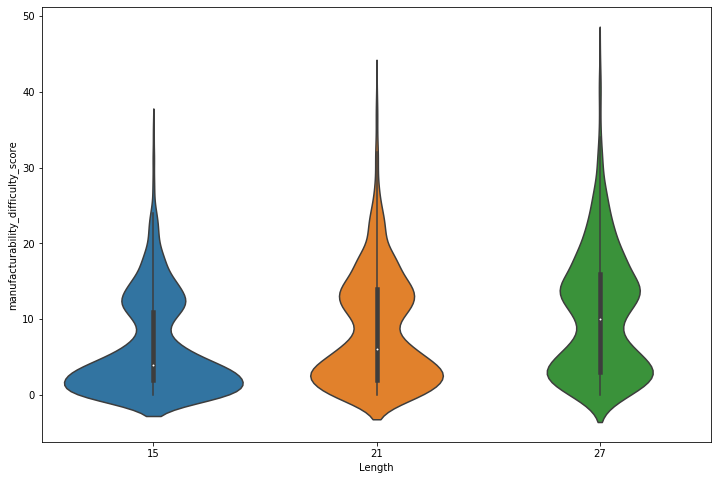

In [78]:
import seaborn 
import matplotlib 
from matplotlib import pyplot
fig = pyplot.figure(figsize=(12,8))

seaborn.violinplot(data=df_concat, x="Length", y="manufacturability_difficulty_score")

In [79]:
bcell_epitopes = pd.read_csv("../bcell/accessible-linear-bcell-epitopes-grouped-merged-filtered.csv", index_col=0)

In [80]:
bcell_epitopes

,num_sources,sources,accessible_subsequence_start,accessible_subsequence_end,accessible_subsequence,accessible_subsequence_length,accessible_subsequence_is_4mer_or_longer,IgG,IgA,IgG_and_IgA,accessible_subsequence_contains_polymorphism,accessible_subsequence_contains_glycosite,near_any_feature,in_any_feature
9,3,Wang 2020 S456-460; Dahlke 2020 S449-463; Char...,457,473,RKSNLKPFERDISTEIY,17,True,True,True,True,False,False,True,True
12,4,Charite 2020 S569-583; Charite 2020 S571-585; ...,580,583,QTLE,4,True,True,True,True,False,False,True,False
17,6,Poh 2020 S809-826; Wang 2020 S806-820; Charite...,809,812,PSKP,4,True,True,True,True,False,False,True,False
21,2,Dahlke 2020 S1131-1145; Charite 2020 S1141-1155,1142,1146,QPELD,5,True,True,True,True,False,False,True,False


In [85]:

from collections import OrderedDict

def annotate_overlapping_bcell_epitopes(df, bcell_epitopes):
    cols = OrderedDict([
        ("overlapping_bcell_epitope", []),
        ("overlapping_bcell_epitope_start", []),
        ("overlapping_bcell_epitope_end", []),
        ("overlapping_bcell_epitope_length", []),
        ("fraction_of_full_bcell_epitope", []),
        ("full_bcell_epitope", []),
    ])

    for (prot, start, end) in zip(df_concat.Protein, df_concat.Start, df_concat.End):
        found_bcell_epitope = False
        if prot == "S":
            for (epitope, epitope_start, epitope_end) in zip(
                    bcell_epitopes.accessible_subsequence,
                    bcell_epitopes.accessible_subsequence_start,
                    bcell_epitopes.accessible_subsequence_end):
                if end >= epitope_start and start <= epitope_end:
                    found_bcell_epitope = True
                    overlap_start = max(epitope_start, start)
                    overlap_end = min(epitope_end, end)
                    overlap_length = overlap_end - overlap_start + 1
                    overlapping_bcell_epitope = epitope[
                        overlap_start - epitope_start:
                        overlap_end - epitope_start + 1]
                    overlap_percent_of_full_bcell_epitope = overlap_length / len(epitope)

                    cols["overlapping_bcell_epitope"].append(overlapping_bcell_epitope)
                    cols["overlapping_bcell_epitope_start"].append(overlap_start)
                    cols["overlapping_bcell_epitope_end"].append(overlap_end)
                    cols["overlapping_bcell_epitope_length"].append(overlap_length)
                    cols["fraction_of_full_bcell_epitope"].append(overlap_percent_of_full_bcell_epitope)
                    cols["full_bcell_epitope"].append(epitope)
                    break
        if not found_bcell_epitope:
            cols["overlapping_bcell_epitope"].append(None)
            cols["overlapping_bcell_epitope_start"].append(None)
            cols["overlapping_bcell_epitope_end"].append(None)
            cols["overlapping_bcell_epitope_length"].append(0)
            cols["fraction_of_full_bcell_epitope"].append(0.0)
            cols["full_bcell_epitope"].append(None)
        
    df_with_bcell_epitopes = df.copy()
    for (col_name, col_values) in cols.items():
        df_with_bcell_epitopes[col_name] = col_values
    return df_with_bcell_epitopes

df_with_bcell_epitopes = annotate_overlapping_bcell_epitopes(df_concat, bcell_epitopes);
df_with_bcell_epitopes

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,difficult_local_hydrophobicity,too_many_cysteines,manufacturability_difficulty_score,Length,overlapping_bcell_epitope,overlapping_bcell_epitope_start,overlapping_bcell_epitope_end,overlapping_bcell_epitope_length,fraction_of_full_bcell_epitope,full_bcell_epitope
0,MFVFLVLLPLVSSQC,S,1,15,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,19.0,15,None,NaN,NaN,0,0.0,None
1,FVFLVLLPLVSSQCV,S,2,16,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,15.0,15,None,NaN,NaN,0,0.0,None
2,VFLVLLPLVSSQCVN,S,3,17,NaN,NaN,0.0,VFLVLLPLVSSQCVN,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
3,FLVLLPLVSSQCVNL,S,4,18,NaN,NaN,0.0,FLVLLPLVSSQCVNL,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
4,LVLLPLVSSQCVNLT,S,5,19,NaN,NaN,0.0,LVLLPLVSSQCVNLT,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,DSTQAMGYINVFAFPFTIYSLLLCRMN,N,415,441,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1910,STQAMGYINVFAFPFTIYSLLLCRMNS,N,416,442,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1911,TQAMGYINVFAFPFTIYSLLLCRMNSR,N,417,443,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1912,QAMGYINVFAFPFTIYSLLLCRMNSRN,N,418,444,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,22.0,27,None,NaN,NaN,0,0.0,None


In [86]:
print(df_with_bcell_epitopes.columns)

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length',
       'overlapping_bcell_epitope', 'overlapping_bcell_epitope_start',
       'overlapping_bcell_epitope_end', 'overlapping_bcell_epitope_length',
       'fraction_of_full_bcell_epitope', 'full_bcell_epitope'],
      dtype='object')


In [87]:
df_with_bcell_epitopes["Mouse MHC-I b"].describe()

count         1325
unique          74
top       TILTRPLL
freq            42
Name: Mouse MHC-I b, dtype: object

In [92]:
df_with_bcell_epitopes["manufacturability_feasibility_score"] = 2.0 ** (
    -df_with_bcell_epitopes.manufacturability_difficulty_score / 10.0)
df_with_bcell_epitopes["mouse class I count"] = (
    (~df_with_bcell_epitopes["Mouse MHC-I d"].isnull()).astype(int) + 
    (~df_with_bcell_epitopes["Mouse MHC-I b"].isnull()).astype(int)
)
df_with_bcell_epitopes["mouse class II count"] = (
    (~df_with_bcell_epitopes["Mouse MHC-II d"].isnull()).astype(int) + 
    (~df_with_bcell_epitopes["Mouse MHC-II b"].isnull()).astype(int)
)

df_with_bcell_epitopes.to_csv(
    "vaccine-peptides-with-bcell-epitopes-and-manufacturability.csv", 
    index=False)

In [107]:
def select_bcell_vaccine_peptides(df):
    sort_columns = [
        "fraction_of_full_bcell_epitope",
        "HLA-II_pop_freq",
        "manufacturability_feasibility_score",
        "HLA-I_pop_freq",
        "mouse class II count",
        "mouse class I count",
    ]
    selected_peptides = set()
    dataframes = []
    for length, df_length in df.groupby("Length"):
        for epitope, df_epitope in df_length.groupby("full_bcell_epitope"):
            df_sorted = df_epitope.sort_values(by=sort_columns, ascending=False)
            
            selected_peptides.add(df_sorted.Sequence.iloc[0])
            dataframes.append(df_sorted.iloc[:1])
            
            has_class2_h2b = ~df_sorted['Mouse MHC-II b'].isnull()
            has_class2_h2d = ~df_sorted['Mouse MHC-II d'].isnull()
            has_both = has_class2_h2b & has_class2_h2d
            
            both = df_sorted[has_both]
            if len(both) > 0 and both.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(both.Sequence.iloc[0])
                dataframes.append(both.iloc[:1])
            
            h2b = df_sorted[has_class2_h2b]
            if len(h2b) > 0 and h2b.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2b.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
            
            h2d = df_sorted[has_class2_h2d]
            if len(h2d) > 0 and h2d.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2d.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
    return pd.concat(dataframes).sort_values(["Length", "Protein", "Start"])


In [111]:
df_selected_bcell_vaccine_peptides = select_bcell_vaccine_peptides(df_with_bcell_epitopes)
for length, df_length in df_selected_bcell_vaccine_peptides.groupby("Length"):
    df_length.to_csv("selected-bcell-vaccine-%dmer.csv" % length, index=False)
df_selected_bcell_vaccine_peptides

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,Length,overlapping_bcell_epitope,overlapping_bcell_epitope_start,overlapping_bcell_epitope_end,overlapping_bcell_epitope_length,fraction_of_full_bcell_epitope,full_bcell_epitope,manufacturability_feasibility_score,mouse class I count,mouse class II count
457,KSNLKPFERDISTEI,S,458,472,"KPFERDISTEI,KSNLKPFER","HLA-B*07:02,HLA-A*11:01",0.286880,NaN,NaN,0.000000,...,15,KSNLKPFERDISTEI,458.0,472.0,15,0.882353,RKSNLKPFERDISTEIY,1.000000,0,0
467,ISTEIYQAGSTPCNG,S,468,482,NaN,NaN,0.000000,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,15,ISTEIY,468.0,473.0,6,0.352941,RKSNLKPFERDISTEIY,0.435275,0,1
568,IADTTDAVRDPQTLE,S,569,583,NaN,NaN,0.000000,NaN,NaN,0.000000,...,15,QTLE,580.0,583.0,4,1.000000,QTLE,1.000000,0,0
798,GFNFSQILPDPSKPS,S,799,813,NaN,NaN,0.000000,GFNFSQILPDPSKPS,"HLA-DRB1*01:01,HLA-DRB1*04:01",0.233805,...,15,PSKP,809.0,812.0,4,1.000000,PSKP,1.000000,0,1
1131,IVNNTVYDPLQPELD,S,1132,1146,VYDPLQPEL,HLA-C*04:01,0.231730,NaN,NaN,0.000000,...,15,QPELD,1142.0,1146.0,5,1.000000,QPELD,0.812252,1,0
452,YRLFRKSNLKPFERDISTEIY,S,453,473,"FRKSNLKPF,KPFERDISTEI,KSNLKPFER,RLFRKSNL,RLFRK...","HLA-C*07:02,HLA-B*07:02,HLA-A*11:01,HLA-B*08:0...",0.780469,YRLFRKSNLKPFERD,HLA-DRB1*07:01,0.226271,...,21,RKSNLKPFERDISTEIY,457.0,473.0,17,1.000000,RKSNLKPFERDISTEIY,1.000000,1,0
461,KPFERDISTEIYQAGSTPCNG,S,462,482,KPFERDISTEI,HLA-B*07:02,0.200499,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,21,KPFERDISTEIY,462.0,473.0,12,0.705882,RKSNLKPFERDISTEIY,0.435275,0,1
579,QTLEILDITPCSFGGVSVITP,S,580,600,ILDITPCSF,HLA-C*05:01,0.133120,DITPCSFGGVSVITP,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,21,QTLE,580.0,583.0,4,1.000000,QTLE,0.615572,0,0
793,IKDFGGFNFSQILPDPSKPSK,S,794,814,ILPDPSKPSK,HLA-A*03:01,0.214307,"FGGFNFSQILPDPSK,FNFSQILPDPSKPSK,GFNFSQILPDPSKP...","HLA-DRB1*04:01,HLA-DRB1*01:01",0.233805,...,21,PSKP,809.0,812.0,4,1.000000,PSKP,1.000000,0,1
1125,CDVVIGIVNNTVYDPLQPELD,S,1126,1146,VYDPLQPEL,HLA-C*04:01,0.231730,"CDVVIGIVNNTVYDP,DVVIGIVNNTVYDPL",HLA-DRB1*01:01,0.130464,...,21,QPELD,1142.0,1146.0,5,1.000000,QPELD,0.287175,1,0


In [120]:
def select_tcell_vaccine_peptides(df, num_per_length=1):
    sort_columns = [
        "HLA-I_pop_freq",
        "HLA-II_pop_freq",
        "manufacturability_feasibility_score",
        "mouse class I count",
        "mouse class II count",
    ]
    selected_peptides = set()
    dataframes = []
    for length, df_length in df.groupby("Length"):
        for prot, df_protein in df_length.groupby("Protein"):
            df_sorted = df_protein.sort_values(by=sort_columns, ascending=False)
            selected_peptides.update(df_sorted.Sequence.iloc[:num_per_length])
            dataframes.append(df_sorted.iloc[:num_per_length])

            has_class2_h2b = ~df_sorted['Mouse MHC-I b'].isnull()
            has_class2_h2d = ~df_sorted['Mouse MHC-I d'].isnull()
            has_both = has_class2_h2b & has_class2_h2d

            both = df_sorted[has_both]
            if len(both) > 0 and both.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(both.Sequence.iloc[0])
                dataframes.append(both.iloc[:1])

            h2b = df_sorted[has_class2_h2b]
            if len(h2b) > 0 and h2b.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2b.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])

            h2d = df_sorted[has_class2_h2d]
            if len(h2d) > 0 and h2d.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2d.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
    return pd.concat(dataframes).sort_values(["Length", "Protein", "Start"])


In [122]:
df_selected_tcell_vaccine_peptides = select_tcell_vaccine_peptides(df_with_bcell_epitopes);
for length, df_length in df_selected_tcell_vaccine_peptides.groupby("Length"):
    df_length.to_csv("selected-tcell-vaccine-%dmer.csv" % length, index=False)
df_selected_tcell_vaccine_peptides

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,Length,overlapping_bcell_epitope,overlapping_bcell_epitope_start,overlapping_bcell_epitope_end,overlapping_bcell_epitope_length,fraction_of_full_bcell_epitope,full_bcell_epitope,manufacturability_feasibility_score,mouse class I count,mouse class II count
1312,ANRNRFLYIIKLIFL,M,40,54,"ANRNRFLYI,FLYIIKLIFL,NRFLYIIKL,NRNRFLYII,RFLYI...","HLA-B*08:01,HLA-A*02:01,HLA-C*06:02,HLA-C*07:0...",0.810623,NaN,NaN,0.000000,...,15,None,NaN,NaN,0,0.000000,None,0.435275,2,0
1804,SASAFFGMSRIGMEV,N,310,324,"ASAFFGMSR,GMSRIGMEV,SAFFGMSRI","HLA-A*11:01,HLA-A*02:01,HLA-C*03:04",0.555082,SASAFFGMSRIGMEV,"HLA-DQA1*05:05/DQB1*03:01,HLA-DRB1*11:01,HLA-D...",0.370708,...,15,None,NaN,NaN,0,0.000000,None,0.659754,2,0
263,AYYVGYLQPRTFLLK,S,264,278,"GYLQPRTFL,GYLQPRTFLL,YLQPRTFL,YLQPRTFLL,YLQPRT...","HLA-C*07:02,HLA-A*24:02,HLA-B*08:01,HLA-A*02:0...",0.882897,AYYVGYLQPRTFLLK,HLA-DRB1*07:01,0.226271,...,15,None,NaN,NaN,0,0.000000,None,1.000000,1,1
447,NYNYLYRLFRKSNLK,S,448,462,"NYNYLYRLF,RLFRKSNL,RLFRKSNLK,YRLFRKSNL,YRLFRKSNLK","HLA-A*24:02,HLA-C*07:02,HLA-B*08:01,HLA-A*03:0...",0.772164,NYNYLYRLFRKSNLK,"HLA-DRB1*11:01,HLA-DRB1*13:01",0.204467,...,15,RKSNLK,457.0,462.0,6,0.352941,RKSNLKPFERDISTEIY,0.933033,2,0
1306,LLQFAYANRNRFLYIIKLIFL,M,34,54,"ANRNRFLYI,AYANRNRFL,FAYANRNRF,FAYANRNRFL,FLYII...","HLA-B*08:01,HLA-C*07:02,HLA-B*35:01,HLA-C*03:0...",0.889819,"FAYANRNRFLYIIKL,LLQFAYANRNRFLYI,LQFAYANRNRFLYI...","HLA-DRB1*13:01,HLA-DRB1*03:01,HLA-DRB1*11:01",0.361583,...,21,None,NaN,NaN,0,0.000000,None,0.435275,2,2
1804,SASAFFGMSRIGMEVTPSGTW,N,310,330,"ASAFFGMSR,GMEVTPSGTW,GMSRIGMEV,MEVTPSGTW,SAFFG...","HLA-A*11:01,HLA-B*44:02,HLA-B*44:03,HLA-A*02:0...",0.648733,"ASAFFGMSRIGMEVT,SAFFGMSRIGMEVTP,SASAFFGMSRIGMEV","HLA-DRB1*11:01,HLA-DRB1*13:01,HLA-DQA1*05:05/D...",0.370708,...,21,None,NaN,NaN,0,0.000000,None,0.659754,2,0
1808,FFGMSRIGMEVTPSGTWLTYT,N,314,334,"VTPSGTWLTY,GMEVTPSGTW,GMSRIGMEV,MEVTPSGTW,TPSG...","HLA-A*01:01,HLA-B*35:01,HLA-B*44:02,HLA-B*44:0...",0.687534,MSRIGMEVTPSGTWL,HLA-DRB1*04:01,0.118847,...,21,None,NaN,NaN,0,0.000000,None,0.757858,0,0
257,WTAGAAAYYVGYLQPRTFLLK,S,258,278,"AAAYYVGYL,GYLQPRTFL,GYLQPRTFLL,WTAGAAAYY,YLQPR...","HLA-C*03:04,HLA-C*07:02,HLA-A*24:02,HLA-A*01:0...",0.910444,"AYYVGYLQPRTFLLK,GAAAYYVGYLQPRTF,WTAGAAAYYVGYLQP","HLA-DRB1*07:01,HLA-DRB1*15:01,HLA-DQA1*05:05/D...",0.513239,...,21,None,NaN,NaN,0,0.000000,None,1.000000,2,1
1306,LLQFAYANRNRFLYIIKLIFLWLLWPV,M,34,60,"ANRNRFLYI,AYANRNRFL,FAYANRNRF,FAYANRNRFL,FLYII...","HLA-B*08:01,HLA-C*07:02,HLA-B*35:01,HLA-C*03:0...",0.889819,"FAYANRNRFLYIIKL,LLQFAYANRNRFLYI,LQFAYANRNRFLYI...","HLA-DRB1*13:01,HLA-DRB1*03:01,HLA-DRB1*11:01",0.361583,...,27,None,NaN,NaN,0,0.000000,None,0.435275,2,2
1801,FAPSASAFFGMSRIGMEVTPSGTWLTY,N,307,333,"ASAFFGMSR,VTPSGTWLTY,GMEVTPSGTW,GMSRIGMEV,MEVT...","HLA-A*11:01,HLA-A*01:01,HLA-B*35:01,HLA-B*44:0...",0.761339,"MSRIGMEVTPSGTWL,APSASAFFGMSRIGM,ASAFFGMSRIGMEV...","HLA-DRB1*04:01,HLA-DRB1*11:01,HLA-DRB1*13:01,H...",0.445497,...,27,None,NaN,NaN,0,0.000000,None,0.659754,2,0


In [ ]:
df_selected_tcell_vaccine_peptides.to_csv("")